### Paquette Profit Function (Total Absolute Gain)

$$
\Pi:= \sum_{\textit{weeks with output } 1} 1 \cdot (\text{Close} - \text{Open}) + \sum_{\textit{weeks with output } -1} -1 \cdot (\text{Close} - \text{Open}) = \sum_{\textit{all weeks}} \text{Output}_{\text{week}} \cdot (\text{Close} - \text{Open})
$$

### Gian Gain Function (Total Return)

The total return over all weeks, $\Gamma$, can be expressed as:

$$
\Gamma = \prod_{t=1}^{T} \left(1 + \text{PortfolioReturn}_t\right) - 1
$$

Where $\text{PortfolioReturn}_t$ for each week $t$ is:

$$
\text{Portfolio\_Return}_t = 
\begin{cases} 
\frac{\text{Next\_week\_pct\_change}_t}{100} & \text{if } \text{Output}_t = 1 \\
-\frac{\text{Next\_week\_pct\_change}_t}{100} & \text{if } \text{Output}_t = -1 \\
0 & \text{if } \text{Output}_t = 0
\end{cases}
$$

Substituting this back into the total return calculation, we get:

$$
\Gamma = \prod_{t=1}^{T} \left(1 + \frac{\text{Next\_week\_pct\_change}_t}{100} \cdot \text{Output}_t \right) - 1 = 
$$


In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import sys
#sys.path.append(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\anfis_libraries')
sys.path.append(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\anfis_gian')

import anfis
import membership 
import experimental
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nolds

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
#msft = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Microsoft_weekly_ok.csv')
#amzn = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Amazon_weekly_ok.csv')
amzn = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Amazon_weekly_ok.csv', index_col=False, parse_dates=['Date'])
#ibm = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\IBM_weekly_ok.csv')
#cac = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Cac_weekly_ok.csv')
#sp500 = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Sp500_weekly_ok.csv')
#nasdaq = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Nasdaq_weekly_ok.csv')

In [3]:
# Function to add indicators
def calculate_rsi(df, rsi_period=14):
    # Calculate RSI (Relative Strength Index)
    price_change = df['Close'].diff()
    upward_changes = price_change.clip(lower=0)
    downward_changes = -price_change.clip(upper=0)
    average_upward_changes = upward_changes.rolling(window=rsi_period).mean()
    average_downward_changes = downward_changes.rolling(window=rsi_period).mean()
    relative_strength = average_upward_changes / average_downward_changes
    df['RSI'] = 100 - (100 / (1 + relative_strength))

    return df

def calculate_cci(df, cci_period=20):
    # Calculate CCI (Commodity Channel Index)
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    sma_typical_price = typical_price.rolling(window=cci_period).mean()
    mean_deviation = (typical_price - sma_typical_price).abs().rolling(window=cci_period).mean()
    df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)

    return df

def calculate_emadn(df, ema_short_period=10, ema_long_period=40):
    ema_short_column = f'EMA{ema_short_period}'
    ema_long_column = f'EMA{ema_long_period}'
    ema_difference_column = f'EMA{ema_short_period}_EMA{ema_long_period}_Difference_Normalized'

    # Calculate short and long period exponential moving averages
    df[ema_short_column] = df['Close'].ewm(span=ema_short_period, adjust=False).mean()
    df[ema_long_column] = df['Close'].ewm(span=ema_long_period, adjust=False).mean()

    # Calculate the difference of exponential moving averages
    df[ema_difference_column] = (df[ema_short_column] - df[ema_long_column])/df[ema_long_column]

    return df

def calculate_cpc(df, cpc_window=4):
    # Calculate CPC (Current Price Change)
    rolling_mean_close = df['Close'].rolling(cpc_window).mean()
    df['CPC'] = 1 / (1 + np.exp(-(df['Close'] - rolling_mean_close.shift(1)) / rolling_mean_close.shift(1) * 100))

    return df

def calculate_indicators(df, rsi_period=14, cci_period=20, ema_short_period=10, ema_long_period=40, cpc_window=4):
    calculate_rsi(df, rsi_period)
    calculate_cci(df, cci_period)
    calculate_emadn(df, ema_short_period, ema_long_period)
    calculate_cpc(df, cpc_window)
    
    return df

In [4]:
# List of DataFrames
#dfs = [amzn, cac, ibm, msft, nasdaq, sp500]
dfs=[amzn]

for df in dfs:
    # Verify dates are datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Verify dates are sorted
    df.sort_values('Date', inplace=True)
    
    calculate_indicators(df, rsi_period=40, cci_period=6, ema_short_period=23, ema_long_period=53, cpc_window=45)

# Drop rows with na, depending on parameters chosen for indicators
amzn.dropna(inplace=True)
amzn.reset_index(inplace=True, drop=True)

amzn.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'RSI', 'CCI', 'EMA23', 'EMA53',
       'EMA23_EMA53_Difference_Normalized', 'CPC'],
      dtype='object')

In [5]:
hurst_results = []
for cci_period in range(20, 40, 1):
    df_cci = calculate_rsi(amzn.copy(), cci_period)
    df_cci = df_cci.dropna(subset=['CCI'])  # Drop NaN values to ensure proper Hurst calculation
    H_rs = nolds.hurst_rs(df_cci['CCI'].dropna())
    hurst_results.append({'CCI Period': cci_period, 'Hurst Exponent': H_rs})

# Convert the results into a DataFrame
hurst_results_df = pd.DataFrame(hurst_results)

# Print the DataFrame
print(hurst_results_df)

    CCI Period  Hurst Exponent
0           20        0.588261
1           21        0.586440
2           22        0.586440
3           23        0.586440
4           24        0.586440
5           25        0.586440
6           26        0.600369
7           27        0.586440
8           28        0.593517
9           29        0.590421
10          30        0.586440
11          31        0.600369
12          32        0.586440
13          33        0.586440
14          34        0.600369
15          35        0.588261
16          36        0.586440
17          37        0.588261
18          38        0.600369
19          39        0.588261


In [6]:
hurst_results = []
for cci_period in range(4, 20, 1):
    df_cci = calculate_rsi(amzn.copy(), cci_period)
    df_cci = df_cci.dropna(subset=['CCI'])  # Drop NaN values to ensure proper Hurst calculation
    H_rs = nolds.hurst_rs(df_cci['CCI'].dropna())
    hurst_results.append({'CCI Period': cci_period, 'Hurst Exponent': H_rs})

# Convert the results into a DataFrame
hurst_results_df = pd.DataFrame(hurst_results)

# Print the DataFrame
print(hurst_results_df)

    CCI Period  Hurst Exponent
0            4        0.600369
1            5        0.586440
2            6        0.586440
3            7        0.587509
4            8        0.586440
5            9        0.586440
6           10        0.586440
7           11        0.586440
8           12        0.585630
9           13        0.586440
10          14        0.586440
11          15        0.590421
12          16        0.586440
13          17        0.586440
14          18        0.586440
15          19        0.586440


In [7]:
hurst_results = []
for ema_short_period in range(18, 24, 1):
    for ema_long_period in range(25, 60, 2):
        df_emadn = calculate_emadn(amzn.copy(), ema_short_period, ema_long_period)
        ema_difference_column = f'EMA{ema_short_period}_EMA{ema_long_period}_Difference_Normalized'
        df_emadn = df_emadn.dropna(subset=[ema_difference_column])  # Drop NaN values to ensure proper Hurst calculation
        H_rs = nolds.hurst_rs(df_emadn[ema_difference_column].dropna())
        hurst_results.append({'EMA short Period': ema_short_period, 'EMA long Period': ema_long_period, 'Hurst Exponent': H_rs})

# Convert the results into a DataFrame
hurst_results_df = pd.DataFrame(hurst_results)

# Print the DataFrame
print(hurst_results_df.values)

[[18.         25.          0.89974621]
 [18.         27.          0.90201575]
 [18.         29.          0.90390235]
 [18.         31.          0.90593563]
 [18.         33.          0.90832345]
 [18.         35.          0.91095423]
 [18.         37.          0.91381815]
 [18.         39.          0.91609867]
 [18.         41.          0.91709321]
 [18.         43.          0.9176001 ]
 [18.         45.          0.91799804]
 [18.         47.          0.91832461]
 [18.         49.          0.91859613]
 [18.         51.          0.91898194]
 [18.         53.          0.91938483]
 [18.         55.          0.91979066]
 [18.         57.          0.91998305]
 [18.         59.          0.92006999]
 [19.         25.          0.90113907]
 [19.         27.          0.90332875]
 [19.         29.          0.90540362]
 [19.         31.          0.90793667]
 [19.         33.          0.91061685]
 [19.         35.          0.91349343]
 [19.         37.          0.91601106]
 [19.         39.        

In [8]:
hurst_results = []
for cpc_window in range(25, 60, 2):
    df_cpc = calculate_cpc(amzn.copy(), cpc_window)
    df_cpc = df_cpc.dropna(subset=['CPC'])  # Drop NaN values to ensure proper Hurst calculation
    H_rs = nolds.hurst_rs(df_cpc['CPC'].dropna())
    hurst_results.append({'CPC Period': cpc_window, 'Hurst Exponent': H_rs})

# Convert the results into a DataFrame
hurst_results_df = pd.DataFrame(hurst_results)

# Print the DataFrame
print(hurst_results_df)

    CPC Period  Hurst Exponent
0           25        0.939639
1           27        0.934919
2           29        0.941336
3           31        0.944136
4           33        0.949729
5           35        0.967263
6           37        0.981211
7           39        0.988649
8           41        0.994565
9           43        0.992650
10          45        0.983366
11          47        0.972718
12          49        0.971035
13          51        0.968438
14          53        0.964054
15          55        0.956932
16          57        0.938852
17          59        0.978034


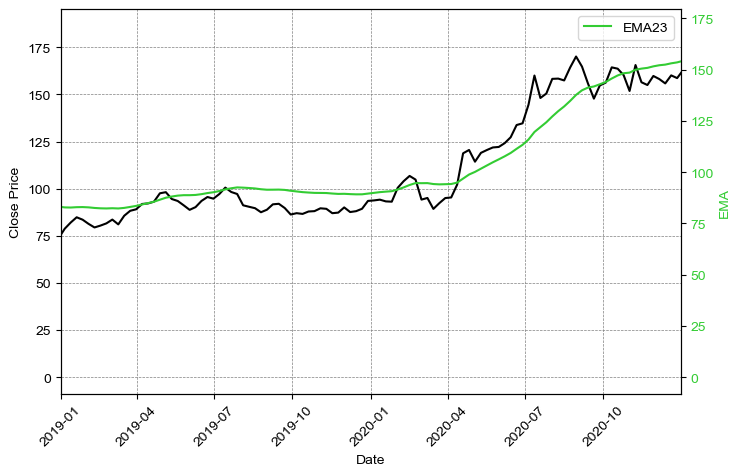

In [9]:
plt.style.use('default')

plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

#ax.legend()

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['EMA23'], color='#33CC33', label='EMA23')
ax2.set_ylabel('EMA', color='#33CC33')
ax2.tick_params(axis='y', labelcolor='#33CC33')
ax2.legend(loc='upper right')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('EMA.png', transparent=True)
plt.show()

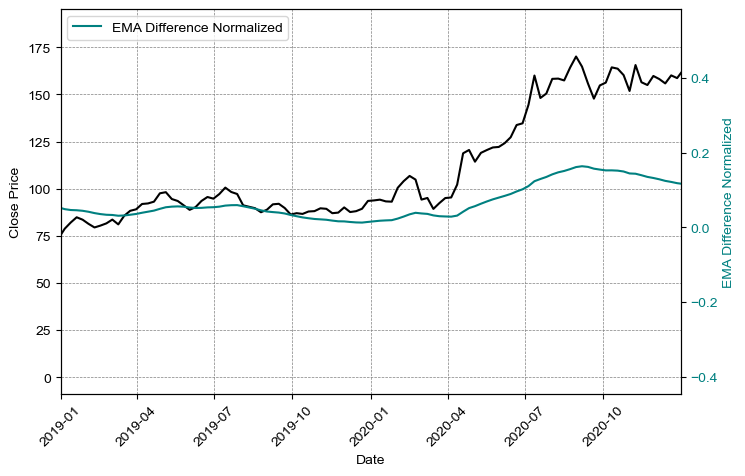

In [10]:
plt.style.use('default')

plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

#ax.legend()

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['EMA23_EMA53_Difference_Normalized'], color='#008080', label='EMA Difference Normalized')
ax2.set_ylabel('EMA Difference Normalized', color='#008080')
ax2.tick_params(axis='y', labelcolor='#008080')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('EMADN.png', transparent=True)
plt.show()

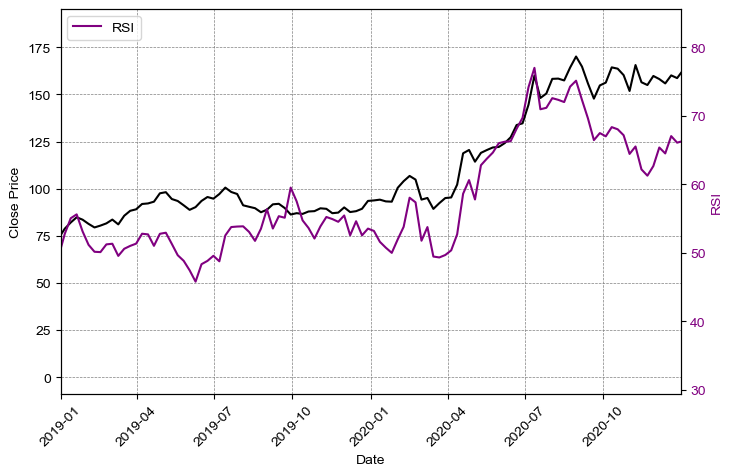

In [11]:
plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['RSI'], color='#800080', label='RSI')
ax2.set_ylabel('RSI', color='#800080')
ax2.tick_params(axis='y', labelcolor='#800080')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('RSI.png', transparent=True)
plt.show()

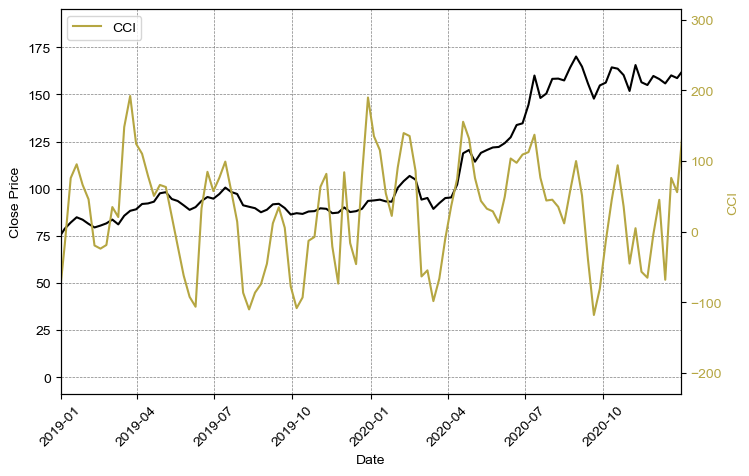

In [12]:
plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['CCI'], color='#B5A642', label='CCI')
ax2.set_ylabel('CCI', color='#B5A642')
ax2.tick_params(axis='y', labelcolor='#B5A642')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('CCI.png', transparent=True)

plt.show()

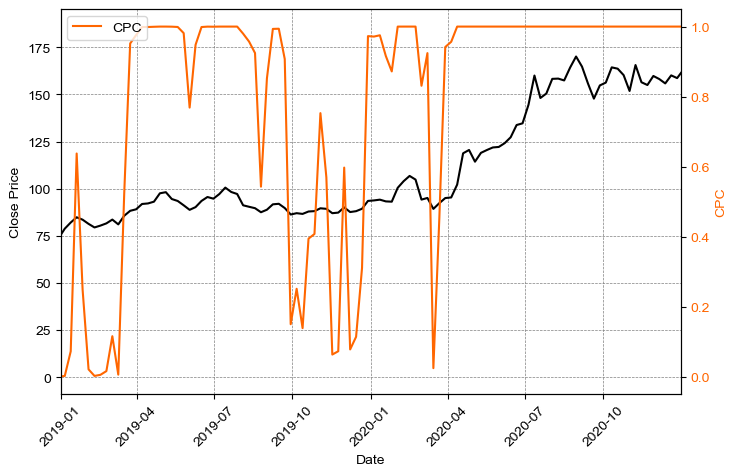

In [13]:
plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['CPC'], color='#FF6600', label='CPC')
ax2.set_ylabel('CPC', color='#FF6600')
ax2.tick_params(axis='y', labelcolor='#FF6600')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('CPC.png', transparent=True)

plt.show()

Target variable is Market Behavior:
- Bullish (upcoming week’s close is higher than the current week’s close): Assign +1.  
- Bearish (upcoming week’s close is lower than the current week’s close): Assign -1.  
- Flat (upcoming week’s close is approximately, according to a threshold, equal to the current week’s close): Assign 0.

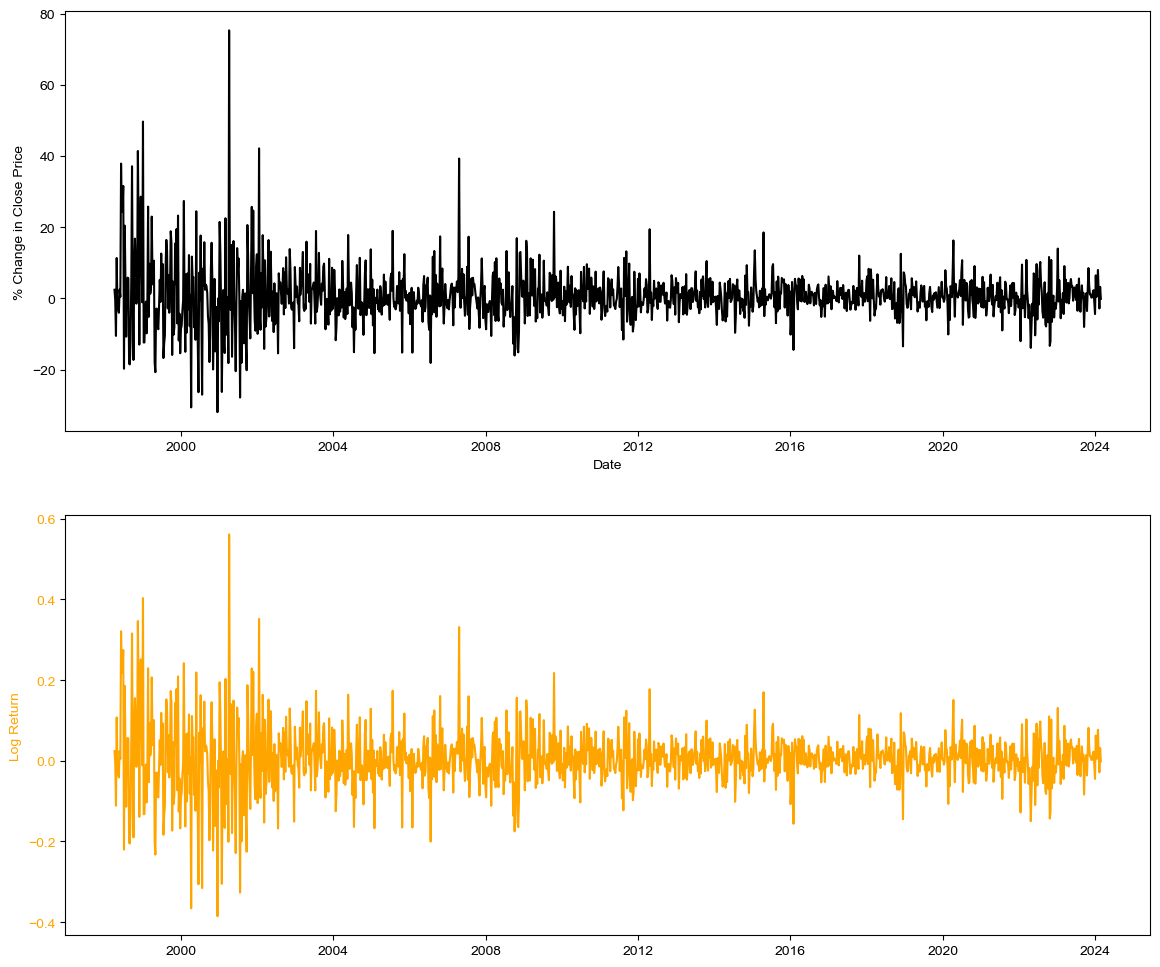

In [14]:
# Calculate the percentage change in closing price from one week to the next
amzn['Current_week_pct_change'] = 100 * amzn['Close'].pct_change(periods=1)
amzn['Next_week_pct_change'] = 100 * amzn['Close'].pct_change(periods=1).shift(-1)

# Define a threshold for what we consider to be a flat week, e.g. 1% price change
# Define a function to categorize the change as +1, 0, or -1
def categorize_change(weekly_return, flat_threshold=0.5):
    if weekly_return > flat_threshold:
        return 1  # Bullish
    elif weekly_return < -flat_threshold:
        return -1  # Bearish
    else:
        return 0  # Flat

# Apply the function to the percentage change column to create the target variable
amzn['Next_week_market_behavior'] = amzn['Next_week_pct_change'].apply(categorize_change)
amzn['Log_return'] = np.log(amzn['Close'].shift(-1) / amzn['Close'])

# Drop the first and last rows as they contain NaN values in the 'Current_week_pct_change' and 'Next_week_pct_change' columns
amzn = amzn.dropna(subset=['Current_week_pct_change', 'Next_week_pct_change'])

fig, axes = plt.subplots(nrows=2, figsize=(14, 12))
axes[0].plot(amzn['Date'], amzn['Next_week_pct_change'], color='Black', label='% change')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('% Change in Close Price', color='Black')
#ax.tick_params(axis='y', labelcolor='white')
#ax.legend()

axes[1].plot(amzn['Date'], amzn['Log_return'], color='orange', label='Log Return')
axes[1].set_ylabel('Log Return', color='orange')
axes[1].tick_params(axis='y', labelcolor='orange')

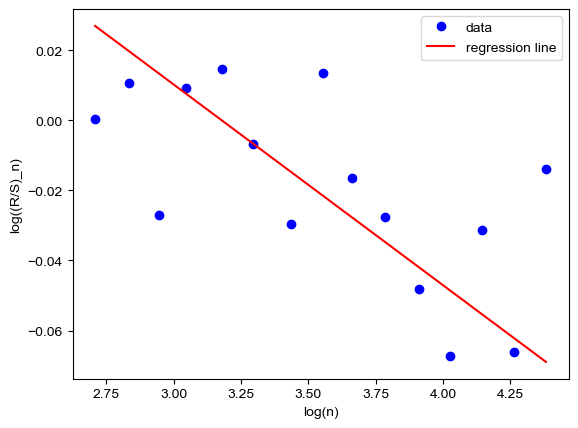

Hurst exponent (R/S): 0.443


In [15]:
H_rs=nolds.hurst_rs(data=amzn['Current_week_pct_change'], debug_plot=True)
print("Hurst exponent (R/S):", round(H_rs,3))

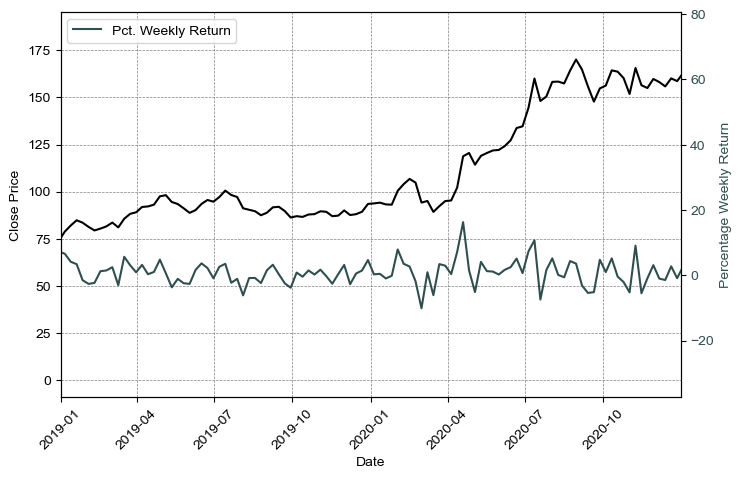

In [16]:
plt.style.use('default')

plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['Current_week_pct_change'], color='#2F4F4F', label='Pct. Weekly Return')
ax2.set_ylabel('Percentage Weekly Return', color='#2F4F4F')
ax2.tick_params(axis='y', labelcolor='#2F4F4F')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('PercentageReturn.png', transparent=True)

plt.show()

In [17]:
# Define your feature columns
feature_columns = ['EMA23_EMA53_Difference_Normalized', 'RSI', 'CCI', 'CPC', 'Current_week_pct_change']

# Now let's prepare the features
features = amzn[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)
print(features)

# Prepare the target to fit the labeling {0,1,2}
target = amzn['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

[[0.74069405 0.84490783 0.54684515 1.         0.38585863]
 [0.74819725 0.8355714  0.52063335 1.         0.32066245]
 [0.75238346 0.81584976 0.52806047 1.         0.29443595]
 ...
 [0.51917573 0.81533538 0.71709316 1.         0.31243038]
 [0.52271753 0.75034926 0.5629503  1.         0.27169465]
 [0.52723301 0.74831137 0.52817441 1.         0.32824845]]


In [18]:
# Define the membership functions for RSI and store in invars:
invars = [
    ('RSI', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('CCI', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('CPC', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('MADN', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('RETURN',[
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ])
]

model = anfis.AnfisNetClassifier(invardefs=invars, num_classes=3)

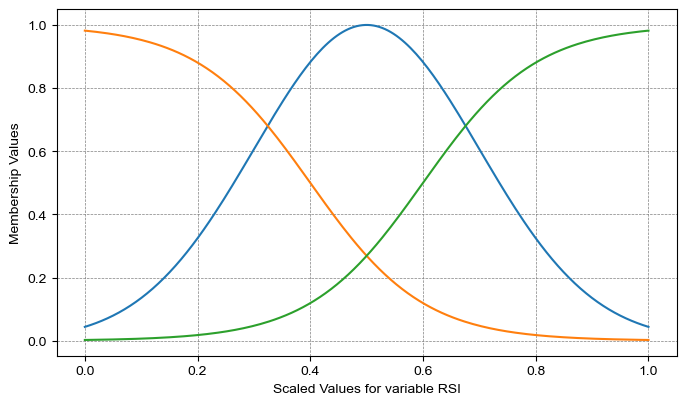

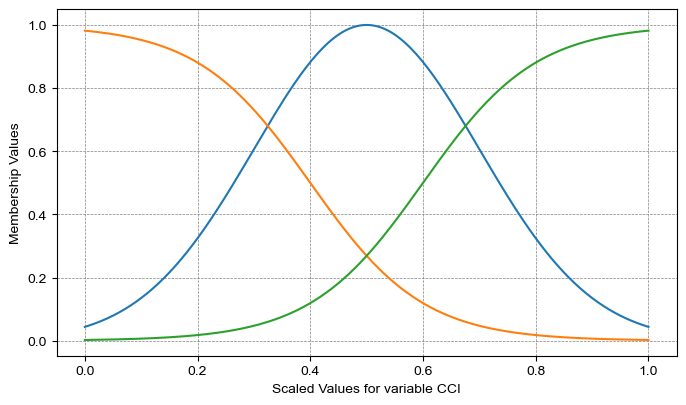

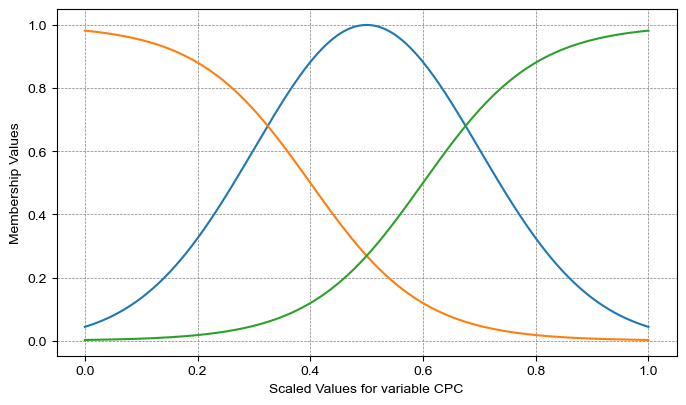

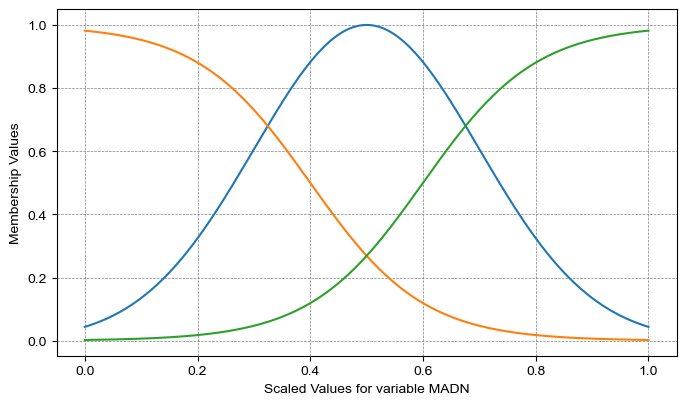

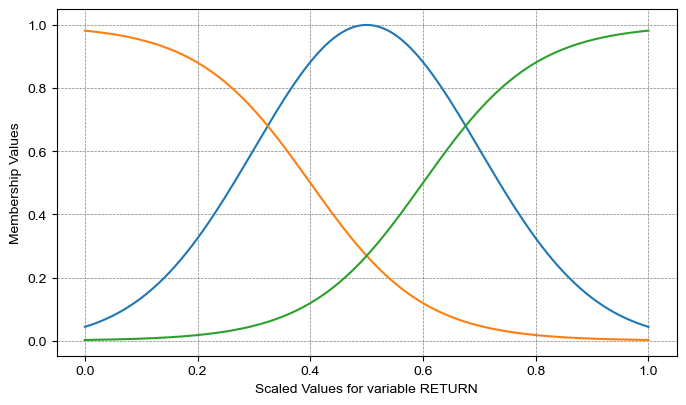

In [19]:
num_points = 200
points_range = torch.linspace(0, 1, num_points)

# Ensure the order matches 'feature_columns' and the model's expectations
x = torch.stack([points_range, points_range, points_range, points_range, points_range], dim=1)  # Adjust the order if necessary

# Now call the plotting function, ensuring your model and the function are ready to use
experimental.plot_all_mfs(model, x)

In [20]:
# model.coeff
# Load the tensor from the file
#loaded_coefficients = torch.load('gianfis_coeff.pt')
#model.coefficients = loaded_coefficients

### Training for 1000 epochs, training size = 1216 cases
epoch    0: Loss=1.09007
epoch   10: Loss=0.96160
epoch   20: Loss=0.92678
epoch   30: Loss=0.91776
epoch   40: Loss=0.91383
epoch   50: Loss=0.91119
epoch   60: Loss=0.90835
epoch   70: Loss=0.90547
epoch   80: Loss=0.90272
epoch   90: Loss=0.90016
epoch  100: Loss=0.89757
epoch  110: Loss=0.89529
epoch  120: Loss=0.89357
epoch  130: Loss=0.89233
epoch  140: Loss=0.89153
epoch  150: Loss=0.89064
epoch  160: Loss=0.88946
epoch  170: Loss=0.88848
epoch  180: Loss=0.88718
epoch  190: Loss=0.88572
epoch  200: Loss=0.88431
epoch  210: Loss=0.88282
epoch  220: Loss=0.88160
epoch  230: Loss=0.88087
epoch  240: Loss=0.87978
epoch  250: Loss=0.87876
epoch  260: Loss=0.87785
epoch  270: Loss=0.87705
epoch  280: Loss=0.87627
epoch  290: Loss=0.87552
epoch  300: Loss=0.87484
epoch  310: Loss=0.87428
epoch  320: Loss=0.87359
epoch  330: Loss=0.87331
epoch  340: Loss=0.87259
epoch  350: Loss=0.87256
epoch  360: Loss=0.87182
epoch  370: Loss=0

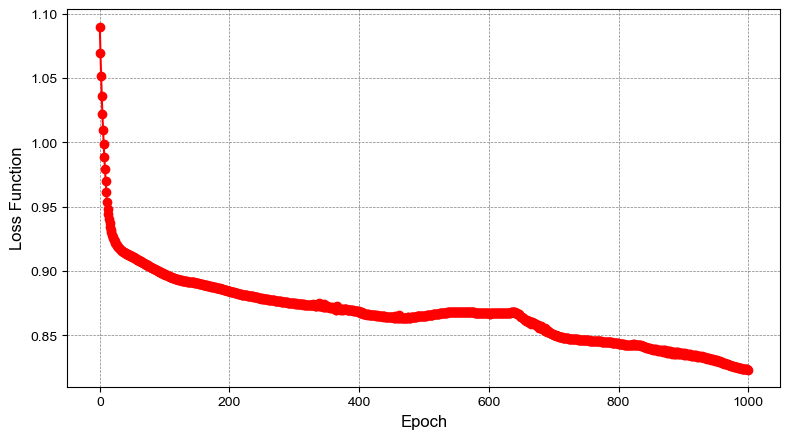

In [21]:
optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, data=train_loader, optimizer=optimizer, epochs=1000, show_plots=True)

In [22]:
# Save consequent layer's parameters
# torch.save(model.coeff, 'gianfis_coeff.pt')

In [23]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

In [24]:
actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Accuracy: {accuracy:.2f}')

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)
print('Confusion Matrix:\n', train_conf_matrix)

# Classification Report
class_report = classification_report(actual_labels_train, predicted_labels_train)
print('Classification Report:\n', class_report)

Accuracy: 0.56
Confusion Matrix:
 [[288   1 236]
 [ 47   6  50]
 [192   3 393]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.55      0.55      0.55       525
           0       0.60      0.06      0.11       103
           1       0.58      0.67      0.62       588

    accuracy                           0.56      1216
   macro avg       0.58      0.43      0.42      1216
weighted avg       0.57      0.56      0.55      1216



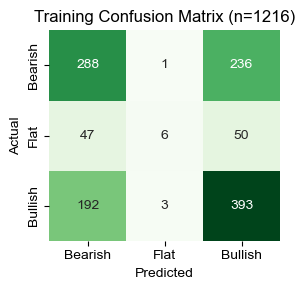

In [25]:
plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
plt.savefig('training_confusion_matrix.png', transparent=True)
plt.show()

In [26]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Accuracy: {accuracy:.2f}')

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)
print('Confusion Matrix:\n', test_conf_matrix)

# Classification Report
class_report = classification_report(actual_labels_test, predicted_labels_test)
print('Classification Report:\n', class_report)

Accuracy: 0.41
Confusion Matrix:
 [[28  0 30]
 [ 9  0  8]
 [33  0 28]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.40      0.48      0.44        58
           0       0.00      0.00      0.00        17
           1       0.42      0.46      0.44        61

    accuracy                           0.41       136
   macro avg       0.27      0.31      0.29       136
weighted avg       0.36      0.41      0.38       136



C:\Users\Gian\anaconda3\envs\ml_project\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gian\anaconda3\envs\ml_project\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gian\anaconda3\envs\ml_project\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


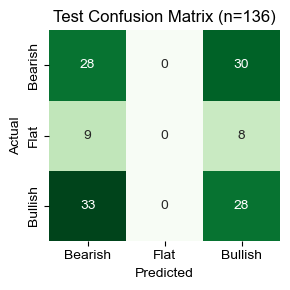

In [27]:
plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Test Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
plt.savefig('test_confusion_matrix.png', transparent=True)
plt.show()

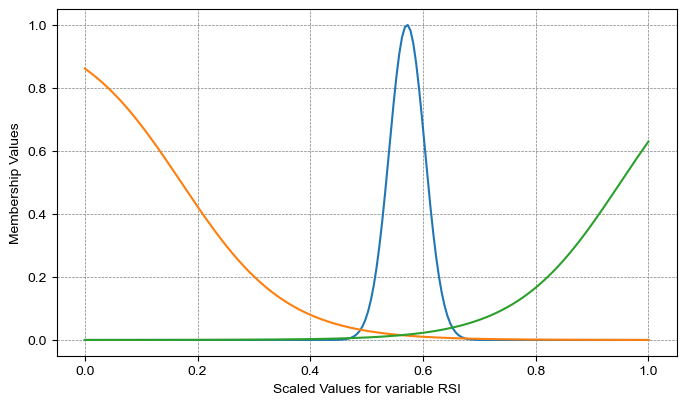

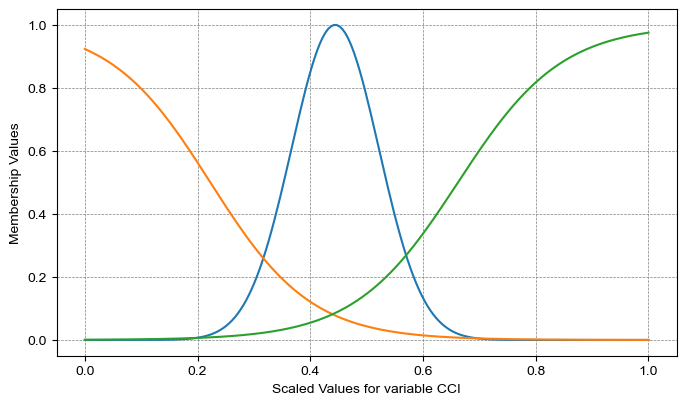

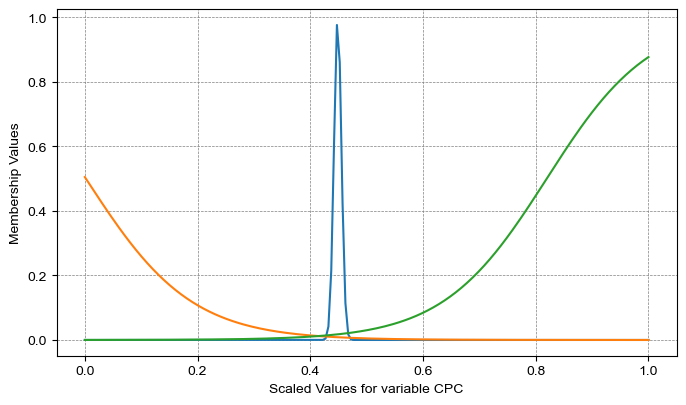

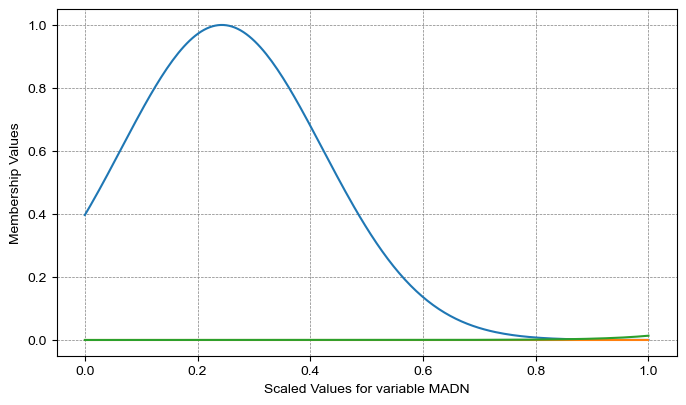

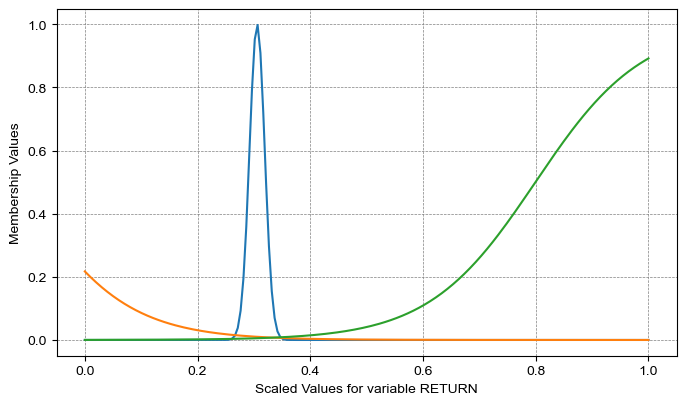

In [28]:
num_points = 200
points_range = torch.linspace(0, 1, num_points)

# Ensure the order matches 'feature_columns' and the model's expectations
x = torch.stack([points_range, points_range, points_range, points_range, points_range], dim=1)  # Adjust the order if necessary

# Now call the plotting function, ensuring your model and the function are ready to use
experimental.plot_all_mfs(model, x)

In [29]:
def calculate_returns(df, prediction_column):
    # Calculate the portfolio return based on the prediction
    df['Shifted_Prediction'] = df[prediction_column].shift(1)
    df['Portfolio_Return'] = df.apply(
        lambda row: (row['Current_week_pct_change'] / 100) * row['Shifted_Prediction'], axis=1
    )
    df.drop(columns=['Shifted_Prediction'], inplace=True)
    
    # Fill NaNs, which would be in the first row after shifting
    df['Portfolio_Return'].fillna(0, inplace=True)

    # Calculate cumulative returns
    df['Cumulative_Return'] = (1 + df['Portfolio_Return']).cumprod() - 1

    # Calculate 'high water mark', i.e. highest cumulative return so far, to visualize drawdowns
    df['High_Water_Mark'] = df['Cumulative_Return'].cummax()

    total_return=df['Cumulative_Return'].iloc[-1]

    print(f'Total return over the dataset: {round(total_return*100, 1)} %')

    return df

def calculate_max_drawdown_duration(df):
    uwater = df['Cumulative_Return'] < df['High_Water_Mark']
    runs = (~uwater).cumsum()[uwater]
    drawdown_durations = runs.value_counts(sort=True)
    return drawdown_durations.iloc[0] if not drawdown_durations.empty else 0

def calculate_yearly_returns(df):
    print('─' * 40)
    df['Year'] = df['Date'].dt.year
    years = df['Year'].unique()
    for year in years:
        year_df=calculate_returns(df[df['Year']==year], 'Prediction')
        max_yearly_drawdown=calculate_max_drawdown_duration(year_df)
        yearly_cumulative_return=year_df['Cumulative_Return'].iloc[-1]

        print(f'Return in year {year}: {round(yearly_cumulative_return * 100, 1)} %')
        print(f'Maximum drawdown during year {year}: {max_yearly_drawdown} weeks')
        print('─' * 40)

def plot_return(df, name, train_test_split=None, save_figure=False):
    plt.style.use('default')

    plt.rcParams['font.sans-serif'] = 'Arial'
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
    if train_test_split!=None:
        # Add line for training/validation split
        split_idx = int(len(df) * train_test_split)
        ax.axvline(x=df['Date'].iloc[split_idx], color='darkgrey', linestyle='--', label='Train/Validation Split')
        
    # Plot cumulative returns and high water mark
    ax.plot(df['Date'], df['Cumulative_Return'], label='Cumulative Return', color='darkgreen', linewidth=1)
    ax.plot(df['Date'], df['High_Water_Mark'], label='Drawdown line', color='darkred', linewidth=1, alpha=0.9)
    ax2=ax.twinx()
    ax2.plot(df['Date'], df['Close'], label='Close price', color='#3498db', alpha=0.5, linewidth=1)
    
    ax.set_title(f'{name} Long-Short Equity Strategy Performance')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return', color='darkgreen')
    ax.tick_params(axis='y', labelcolor='darkgreen')
    ax2.set_ylabel('Adjusted Close price (USD)', color='#3498db') 
    ax2.tick_params(axis='y', labelcolor='#3498db')
    
    fig.legend(loc='upper left', bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)
    if save_figure:
        plt.savefig(f'{name}_gianfis_return.png', transparent=True, dpi=300)
    plt.show()

Total return over the dataset: 79311809.6 %
Maximum Drawdown Duration 163 weeks


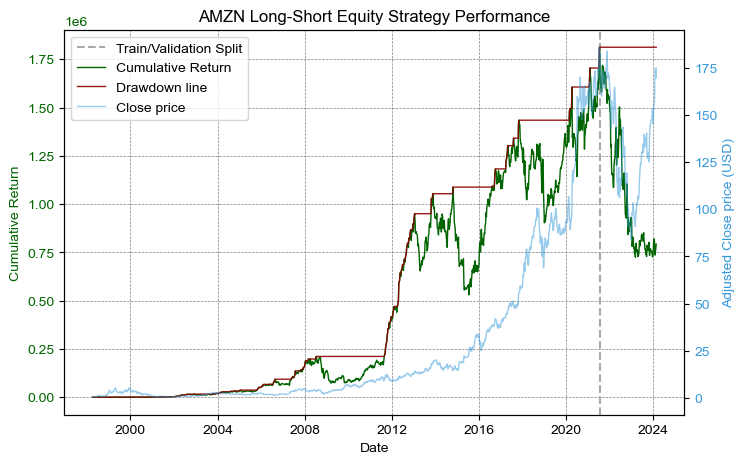

In [30]:
# Combine predictions into a single column
amzn['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

amzn=calculate_returns(amzn, 'Prediction')

max_drawdown_duration=calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

plot_return(amzn, 'AMZN', train_test_split=0.9, save_figure=False)

In [31]:
# Calculate cumulative return for a long-only strategy over the entire period
long_only_returns = (1 + amzn['Current_week_pct_change'] / 100).cumprod() - 1
print(f'WB total return: {round(long_only_returns.iloc[-1]*100, 1)} %')

# Calculate cumulative return for a long-only strategy over the validation set
validation_set = amzn.iloc[split_idx:]
long_only_returns_test = (1 + validation_set['Current_week_pct_change'] / 100).cumprod() - 1
print(f'WB return over validation set: {round(long_only_returns_test.iloc[-1]*100, 1)} %')

WB total return: 49308.5 %
WB return over validation set: -2.1 %


Total return over the dataset: 181249982.6 %
Training Set Maximum Drawdown: 163 weeks


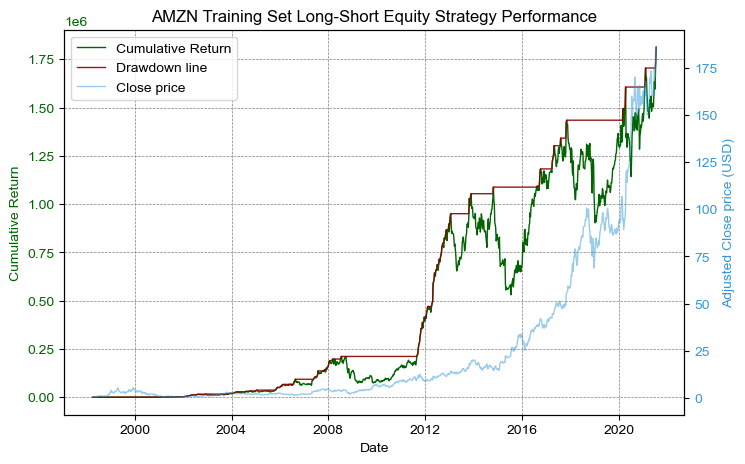

────────────────────────────────────────
Total return over the dataset: -55.2 %
Test Set Maximum Drawdown: 135 weeks


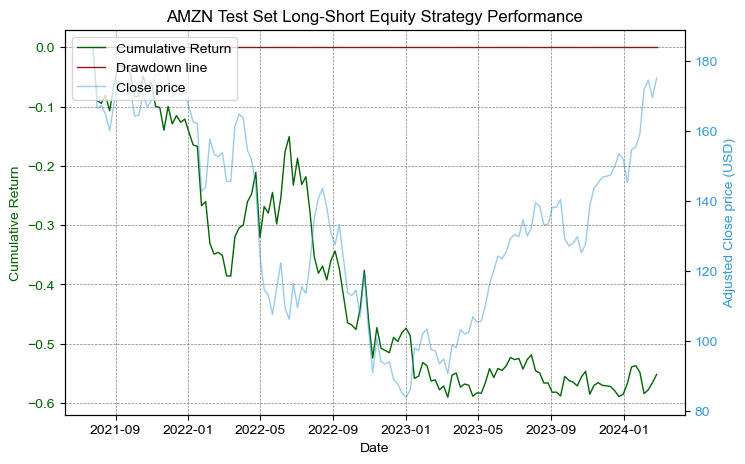

In [32]:
split_idx = int(len(amzn) * 0.9)

amzn_train_df = amzn.iloc[:split_idx].drop(columns=['Open', 'High', 'Low', 'RSI', 'CCI', 'EMA23', 'EMA53',
       'EMA23_EMA53_Difference_Normalized', 'CPC', 'Log_return']).copy()
amzn_test_df = amzn.iloc[split_idx:].drop(columns=['Open', 'High', 'Low', 'RSI', 'CCI', 'EMA23', 'EMA53',
       'EMA23_EMA53_Difference_Normalized', 'CPC', 'Log_return']).copy()

amzn_train_df = calculate_returns(amzn_train_df, 'Prediction')
max_drawdown_duration_train = calculate_max_drawdown_duration(amzn_train_df)
print(f'Training Set Maximum Drawdown: {max_drawdown_duration_train} weeks')
plot_return(amzn_train_df, 'AMZN Training Set')

print('─' * 40)

amzn_test_df = calculate_returns(amzn_test_df, 'Prediction')
max_drawdown_duration_test = calculate_max_drawdown_duration(amzn_test_df)
print(f'Test Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
plot_return(amzn_test_df, 'AMZN Test Set')

In [33]:
calculate_yearly_returns(amzn)

────────────────────────────────────────
Total return over the dataset: 564.3 %
Return in year 1998: 564.3 %
Maximum drawdown during year 1998: 8 weeks
────────────────────────────────────────
Total return over the dataset: 1479.8 %
Return in year 1999: 1479.8 %
Maximum drawdown during year 1999: 7 weeks
────────────────────────────────────────
Total return over the dataset: 399.8 %
Return in year 2000: 399.8 %
Maximum drawdown during year 2000: 21 weeks
────────────────────────────────────────
Total return over the dataset: 245.0 %
Return in year 2001: 245.0 %
Maximum drawdown during year 2001: 19 weeks
────────────────────────────────────────
Total return over the dataset: 413.1 %
Return in year 2002: 413.1 %
Maximum drawdown during year 2002: 14 weeks
────────────────────────────────────────
Total return over the dataset: 59.4 %
Return in year 2003: 59.4 %
Maximum drawdown during year 2003: 17 weeks
────────────────────────────────────────
Total return over the dataset: 64.9 %
Retur